<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 - Many two state systems

We have already seen the interesting physics that can arise from the interaction of a single two-state system (TSS) with a quantised field in the spin boson model. Although there is still more that we can explore there, it's even more interesting to start thinking about what happens when we start to include many TSS.

As soon as we start adding more than one TSS things get quite complicated. In order to give us an intuition for how such systems behave, we will take a small step back in this tutorial and remove the quantised field (don't worry, we'll bring it back in the next tutorial).

This tutorial is split up into the following sections
1. Describing the states
2. Two state system recap
3. Independent two state systems
4. Stationary states
5. Angular momentum
6. Simulation in the Dicke basis
7. Isolated universes

In [17]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals

# The helper file below brings functions created in previous tutorials
# make_df_for_energy_scan - we made this in tutorial 4
# make_braket_labels - we made this in tutorial 4
from libs.helper_05_tutorial import *

# This function takes a list of QuTiP states and puts them in a dataframe to make them easier to visually compare
def prettify_states(states, mm_list=None):
    pretty_states = np.zeros([states[0].shape[0],len(states)], dtype="object")
    
    for j, state in enumerate(states):
        for i, val in enumerate(state):
            pretty_states[i,j] = f"{val[0,0]:.1f}"
    if (mm_list == None):
        df = pd.DataFrame(data=pretty_states)
    else:
        df = pd.DataFrame(data=pretty_states, index=mm_list)
            
    return df

## 5.1 - Describing the states

We'll start simple and look at 2 TSS. We can describe this system by the different possible combinations of the higher (+) and lower (-) energy states of the individual TSS namely:
- $|+,+\rangle$
- $|+,-\rangle$
- $|-,+\rangle$
- $|-,-\rangle$

We can see that 2 TSS is actually a 4 state system. Mathematically these 4 states can be represented as vectors of length 4 using the following basis:

$$
|+,+\rangle = \begin{bmatrix}
 1   \\
 0   \\
 0   \\
 0   \\
 \end{bmatrix}, 
|+,-\rangle = \begin{bmatrix}
 0   \\
 1   \\
 0   \\
 0   \\
\end{bmatrix}, 
|-,+\rangle = \begin{bmatrix}
 0   \\
 0   \\
 1   \\
 0   \\
\end{bmatrix}, 
|-,-\rangle = \begin{bmatrix}
 0   \\
 0   \\
 0   \\
 1   \\
\end{bmatrix}
$$

How do we create these states in QuTiP?

In [Tutorial 3](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb#3.5---Describing-coupled-systems-in-QuTiP) we learnt to describe such states by using the tensor product. For example, we would create the $|+,-\rangle$ state by doing:

In [18]:
pm = tensor(basis(2,0), basis(2,1))
pm

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

and we can keep track of which basis states corresponds to which row of the vector by using the `product` function that we introduced in the previous tutorial. Specifically:

In [19]:
possible_ms = ["+","-"]
mm_list = [mm for mm in product(possible_ms, possible_ms)]
mm_list

[('+', '+'), ('+', '-'), ('-', '+'), ('-', '-')]

So, the row number 1 of the state vector refers to the basis state:

In [20]:
mm_list[1]

('+', '-')

How does such a system behave?

## 5.2 - Two state system recap

We have previously looked at a TSS whose states are allowed to couple to each other with strength $A$. This coupling resulted in a splitting of the stationary states (i.e. states of constant energy). When we perturbed the energy of those states by an amount $\pm \delta$ we found (in [tutorial 02](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#Transition-probability)) that a natural way to represent the Hamiltonian is

$$
H = \begin{bmatrix}
 A  &  \delta  \\
 \delta  &  -A  \\
\end{bmatrix} = A\sigma_z +\delta \sigma_x
$$

The basis states being used to represent this system are the stationary states of the unperturbed system ($\delta=0$) that we describe by:

$$
|+\rangle = \begin{bmatrix}
 1   \\
 0   \\
 \end{bmatrix}, 
|-\rangle = \begin{bmatrix}
 0   \\
 1   \\
\end{bmatrix}
$$

where $|+\rangle$, $|-\rangle$ correspond to the higher and lower energy states respectively. 

You may recall from [tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#Transition-probability) that there are mathematical similarities between a TSS and a spin $1/2$ particle. When considering many TSS, we will find it invaluable to refer to well known spin results, such as conservation of angular momentum, to help us solve problems. In light of this, we will introduce a factor of $1/2$ into the Hamiltonian:

$$
H = \frac{1}{2}A\sigma_z +\frac{1}{2}\delta \sigma_x
$$

so that we can rewrite the Hamiltonian in terms of spin operators, (denoted by $S$), for a [spin $1/2$ particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables), i.e.

$$
H = A S_{z} + \delta S_{x}
$$


## 5.3 - Independent two state systems


A natural starting point for the Hamiltonian of $N$ independent TSS each interacting with a perturbing "field" of strength $\delta$ is to simply add many TSS Hamiltonians together, i.e.

$$
H = A \overset{N}{\underset{n=1}{\Sigma}} S_{n z} +  \delta \overset{N}{\underset{n=1}{\Sigma}} S_{n x} 
$$

Because spin represents angular momentum, the sum of $N$ spin operators above is mathematically the same as how one would create the [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) - denoted by $J$, e.g. $J_x = \overset{N}{\underset{n=1}{\Sigma}} S_{n x}$. The Hamiltonian can then be written more compactly as:

$$
H = A J_{z} +  \delta J_{x}
$$


QuTiP has a nice function, [`jspin`](http://qutip.org/docs/latest/apidoc/functions.html#qutip.piqs.jspin),  to generate the $J$ operators for any given number of TSS (note, you must import [`qutip.piqs`](http://qutip.org/docs/latest/apidoc/functions.html#module-qutip.piqs) to use this).

Let's create the $J$ operators for 2 TSS:

In [21]:
J = jspin(2, basis="uncoupled")

$J$ contains all 3 operators:
- $J_x$ = `J[0]`
- $J_y$ = `J[1]`
- $J_z$ = `J[2]`

Let's see how the $J_z$ operator acts on the $|+,-\rangle$ state we created earlier.

In [22]:
J[2]*pm

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]]

We get zero because $J_z$ is in essence creating a running total of the number of "spin ups" (+)  minus the "spin downs" (-). For $|+,-\rangle$ we have 1 up and 1 down and so we get zero.

To understand how such a system behaves we proceed as we have done several times by looking for the stationary states of the system. When the system is in one of these states it will remain there for all time. Such states are described by a single constant energy.

To find the states of constant energy, we'll follow what we did in [tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#2.1-Static-perturbation). Specifically, we will calculate the eigenvalues and eigenvectors *(sometimes also called eigenstates or eigenkets)* of the Hamiltonian and see how they depend on the the perturbation strength $\delta$.

Let's see what we find.

## 5.4 - Stationary states

First let's create the data structures to store the eigenvalue and eigenvector information.

In [23]:
num_deltas = 100

# df holds the data about the energy of the stationary states
# make_df_for_energy_scan - imported from helper (see top of notebook)
df = make_df_for_energy_scan("$\delta$/A", -4,4, num_deltas, J[0].shape[0]) 

# vec will store the eigenvectors, i.e. the stationary states for each value of delta
vec = np.zeros([J[0].shape[0], J[0].shape[0], num_deltas])

Let's see what we've made

In [24]:
df.head()

,$\delta$/A,level_0,level_1,level_2,level_3
0,-4.000000,0.0,0.0,0.0,0.0
1,-3.919192,0.0,0.0,0.0,0.0
2,-3.838384,0.0,0.0,0.0,0.0
3,-3.757576,0.0,0.0,0.0,0.0
4,-3.676768,0.0,0.0,0.0,0.0


In [25]:
vec.shape

(4, 4, 100)

We'll use the same value for $A$ as in tutorials 1 and 2.

In [26]:
A=0.1

We now go through each value of $\delta$, create the Hamiltonian, find it's eigenvalues and eigenvectors and store the results.

In [27]:
J[2]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. -1.]]

In [28]:
J[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.5 0.5 0. ]
 [0.5 0.  0.  0.5]
 [0.5 0.  0.  0.5]
 [0.  0.5 0.5 0. ]]

In [33]:
for i, row in df.iterrows():
    H = A*J[2] + row[ "$\delta$/A"]*A*tensor(sigmax(), sigmax())
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals
    for j, ket in enumerate(ekets):
        ket = np.transpose(ket)
        vec[j,:,i] = np.abs(ket*np.conj(ket))

Let's have a look at the energy levels first, i.e. the eigenvalues that we stored in `df`.

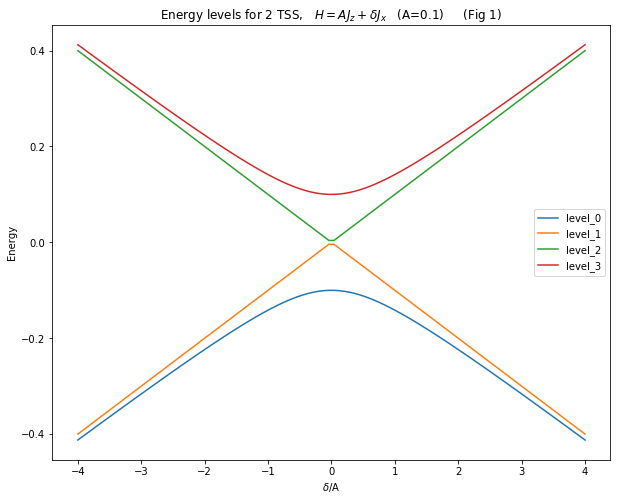

In [34]:
df.plot(x="$\delta$/A",figsize=(10,8),legend=True, 
        title="Energy levels for 2 TSS,   $H=AJ_{z} + \delta J_{x}$   (A=0.1)     (Fig 1)");
plt.ylabel("Energy");

Superficially, Fig 1 resembles Fig 3 of [tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#2.1-Static-perturbation) in that we see an avoided crossing when there is zero perturbation. 

What's more interesting is that 2 of the levels (1 and 2) have the same energy (aka [degenerate](https://en.wikipedia.org/wiki/Degenerate_energy_levels) levels) whose value does not show any dependence on $\delta$. To understand these degenerate states, we need to look at the eigenstates and how they change with $\delta$.

In [35]:
# Create the bra and ket labels for making nice labels for plots
# make_braket_labels - imported from helper (see top of notebook)
bra_labels, ket_labels = make_braket_labels(mm_list)

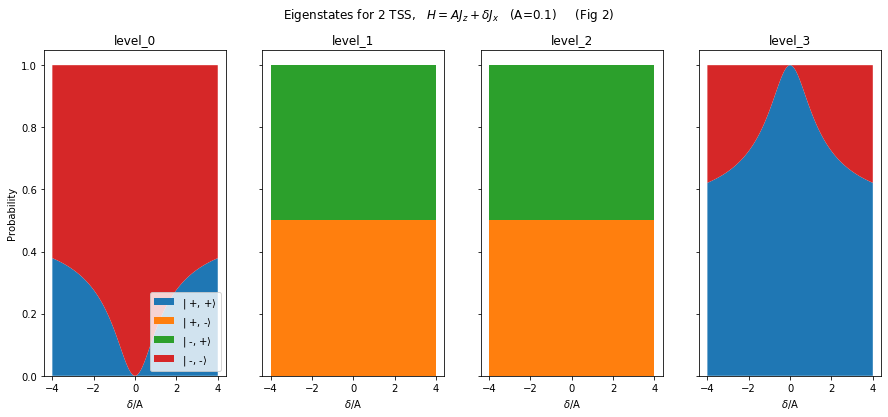

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,6), sharey=True)

for i in range(0,vec.shape[0]):
    axes[i].stackplot(df[ "$\delta$/A"], vec[i,:,:], labels=ket_labels);
    axes[i].set_xlabel("$\delta$/A")
    axes[i].set_title(f"level_{i}")
axes[0].set_ylabel("Probability")
axes[0].legend(loc='lower right')

fig.suptitle('Eigenstates for 2 TSS,   $H=AJ_{z} + \delta J_{x}$   (A=0.1)     (Fig 2)');

Fig 2 shows us what the eigenstates (which corresponds to a particular energy level) are made of, i.e. how much of each basis state makes up each eigenstate. For example, level_0 with $\delta/A = -0.4$, is made up of roughly:
- 40% $|-,- \rangle$ (red)
- 20% $|-,+ \rangle$ (green)
- 25% $|+,- \rangle$ (orange)
- 15% $|+,+ \rangle$ (blue)


We expect the eigenstates to change in a smooth way as we change $\delta$, but we can see that level_1 and level_2 show some spiky behaviour. This is due to the degenerate nature of the energy levels and also the numerical methods used by QuTiP - the eigenstates can sometimes swap their position in the numpy array. We can fix this manually in the following way:

In [15]:
# Looks at level 1 and finds the places where the state |+,+> (blue) has a non zero value i.e. the spiky points
ind = vec[1,0,:] > 0 

# swaps the eigenstates of level_1 and level_2 only at the spiky places
vec[1,:,ind], vec[2,:,ind] = vec[2,:,ind], vec[1,:,ind]

Now let's replot 

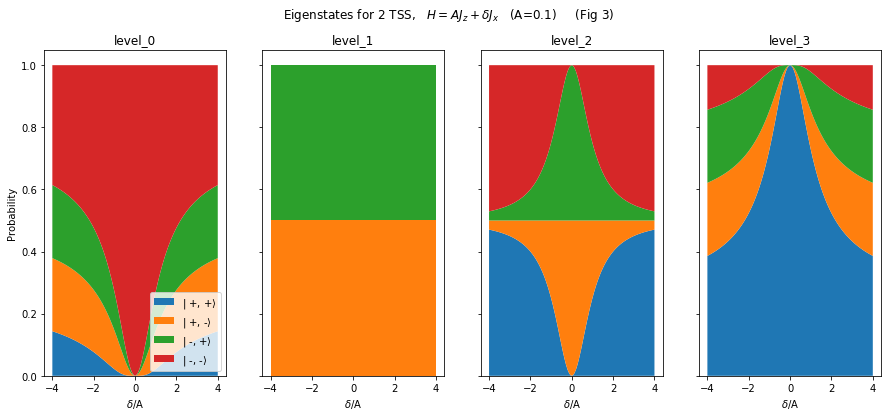

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,6), sharey=True)

for i in range(0,vec.shape[0]):
    axes[i].stackplot(df[ "$\delta$/A"], vec[i,:,:], labels=ket_labels);
    axes[i].set_xlabel("$\delta$/A")
    axes[i].set_title(f"level_{i}")
axes[0].set_ylabel("Probability")
axes[0].legend(loc='lower right')

fig.suptitle('Eigenstates for 2 TSS,   $H=AJ_{z} + \delta J_{x}$   (A=0.1)     (Fig 3)');

Much better. There is a lot to say about Fig 3:
1. As $\delta \rightarrow 0$, level_0 and level_3 behave as you would expect, namely the lowest energy level_0 becomes $|-,-\rangle$, and the highest energy level_3 becomes $|+,+\rangle$
2. Level_1 has no dependency on the perturbation $\delta$
3. As $\delta \rightarrow 0$, level_2 approaches the same as level_1 (within a phase factor)

The indifference of level_1 to $\delta$ seems mysterious - why does this level stand out from the others? In order to solve this mystery, we need to first understand the composition of the eigenstates for small $\delta$.

In [41]:
delta = 0.001
H = A*J[2] + delta*tensor(sigmax(), sigmax())
evals, ekets = H.eigenstates()

In [42]:
# prettify_states - function created at the top of the notebook
prettify_states(ekets, mm_list)

,0,1,2,3
"(+, +)",0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j
"(+, -)",0.0+0.0j,-0.7+0.0j,-0.7+0.0j,0.0+0.0j
"(-, +)",0.0+0.0j,0.7+0.0j,-0.7+0.0j,0.0+0.0j
"(-, -)",-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


We can see that levels 1 and 2 are "in phase" and "out of phase" mixtures of  $|+,-\rangle$ and  $|-,+\rangle$ This kind of combination of basis states is often referred to as an [entangled state](https://en.wikipedia.org/wiki/Quantum_entanglement#Pure_states). 

>The subject of quantum entanglement deserves at least a whole tutorial, so we'll come back to it another time.

When we compare these eigenstates to those from the unperturbed case, i.e. $\delta=0$, we see a significant difference in levels 1 and 2:

In [19]:
H0 =  A*J[2]
evals0, ekets0 = H0.eigenstates()

In [20]:
prettify_states(ekets0, mm_list)

,0,1,2,3
"(+, +)",0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j
"(+, -)",0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
"(-, +)",0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j
"(-, -)",1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


This difference persists even down to the tiniest values of $\delta$. This suggests that there might be a "better" way to represent the states of our system than the one we chose in section 5.1. Specifically, the results are suggesting we use a basis made up those entangled states from above -  something like this (ignoring normalisation factors):

- $|+,+\rangle$
- $|+,-\rangle$ + $|-,+\rangle$
- $|+,-\rangle$ - $|+,+\rangle$
- $|-,-\rangle$

Although our original basis was perfectly fine to use, there is clearly something important to understand about this entangled basis.

What makes the entangled basis special? It has to do with angular momentum.

## 5.5 - Angular momentum

Although we are not dealing explicitly with the physics of spin angular momentum, we are using the same mathematics. For example, we are already using the x and z "components" of the total angular momentum operator $J_x$ and $J_z$. What can we learn from other operators, e.g. what about the "magnitude" of the total angular momentum operator? 

I use quote marks around "component" and "magnitude" because this is vector language which is not obviously applicable to operators. It turns out, however, that we can (in some sense) treat the angular momentum operator as a vector (see [spinors](https://en.wikipedia.org/wiki/Spinors_in_three_dimensions)). We can create the squared magnitude of the total angular momentum operator ($J^2$) much like we would a vector - we sum of the squares of the components.

In [21]:
J2 = J[0]*J[0] + J[1]*J[1] + J[2]*J[2]
J2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

What does this operator tell us?

Just as we learnt about states of constant energy by calculating the eigenvalues and eigenvectors of the Hamiltonian, we can learn about states of constant angular momentum by calculating the eigenvalues and eigenvectors of $J^2$.


In [22]:
evalsJ, eketsJ = J2.eigenstates()

In [23]:
evalsJ

array([1.11022302e-15, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00])

Although not immediately obvious, the eigenvalues of $J^2$ [always have the form $j(j+1)$](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7), where $j$ is a number that characterises the angular momentum of the system with $2j$ being an integer. Therefore, even without explicitly looking at the eigenstates of $J^2$, we know they must correspond to:
- $j=0$ - one state
- $j=1$ - three states

But, where do these $j$ numbers come from, and what does it mean to have many states with the same value of $j$?


In quantum mechanics, it has been found experimentally that [angular momentum is quantised](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7) in the sense that when its z component is measured it can only take values $m\hbar$ where $m = j, (j-1), (j-2), ..., -(j-2), -(j-1), -j$.

So although we still haven't explicitly looked the 4 eigenstates of $J^2$, we can say that they can be uniquely described by 2 numbers $|j, m \rangle$, namely:

- $|0, 0 \rangle$
- $|1, -1 \rangle$
- $|1, 0 \rangle$
- $|1, 1 \rangle$

The specific $j$ and $m$ numbers come from adding up the angular momentum for many single TSS (with $j=1/2$) like vectors of the same length but different (quantised) orientations. The details are somewhat tedious - often involving [formidable lookup tables](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-clebsch-gordan-coefs.pdf). Luckily for us, QuTiP, has some convenient functions (that are somewhat hidden inside of [`qutip.cy.piqs`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx)) to help us.
- [`j_vals(N)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L130) - tells us the different $j$ values for $N$ TSS.
- [`m_vals(j)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L147) tells us the $m$ values for a given $j$

e.g.

In [24]:
j_vals(2)

array([0., 1.])

In [25]:
m_vals(1)

array([-1,  0,  1])

Let's now take a look at the angular momentum eigenstates in the $|±, ± \rangle$ basis and see if we can match them to the corresponding $|j, m \rangle$ that we've just motivated.

In [26]:
prettify_states(eketsJ, mm_list)

,0,1,2,3
"(+, +)",0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
"(+, -)",0.7+0.0j,0.0+0.0j,0.7+0.0j,0.0+0.0j
"(-, +)",-0.7+0.0j,0.0+0.0j,0.7+0.0j,0.0+0.0j
"(-, -)",0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j


Keeping in mind that ± corresponds to $m= ±1/2$ we have:

- $\mathbf{0} = 0.7|+, - \rangle - 0.7|-, + \rangle = |0, 0 \rangle$ ($m=0$ because + and - cancel out, $j=0$ because of anti-parallel addition of states)
- $\mathbf{1} = \ \ \ \ \  |+,+ \rangle \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = |1, 1 \rangle$ 
- $\mathbf{2} = 0.7|+, - \rangle + 0.7|-, + \rangle = |1, 0 \rangle$ ($m=0$ because + and - cancel out, $j=1$ because of parallel addition of states)
- $\mathbf{3} =  \ \ \ \ \  |-,- \rangle \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  = |1, -1 \rangle$ 

You might have noticed that these eigenstates are identical to the mysterious entangled basis states that we encountered earlier. The implication is that we might do a better job of describing many TSS interacting with some field by working in a basis corresponding to states of constant "angular momentum".

Let's have a go and running a simulation using this basis (often called the [Dicke basis](https://journals.aps.org/pr/pdf/10.1103/PhysRev.93.99) - see also [here](http://dx.doi.org/10.1002/qute.201800043)) and see what we find.

## 5.6 - Simulation in the Dicke basis

We've already found the stationary states for a static perturbation above in section 5.4. Let's now proceed as we did in [tutorial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#2.2-Time-dependent-perturbation) and introduce a resonant time dependent perturbation. Specifically, the Hamiltonian will now be:

$$
H = A J_{z} + \delta J_{x} \cos(\omega t)
$$

with $\omega = A$.

The idea is to start the system off in a stationary state of the unperturbed ($\delta=0$) system and then see what happens when we make $\delta= 0.001$. When the system depends explicitly on time, the energy in not conserved and so the system will evolve away from where it started.  Although $\delta$ is small, we know from our previous experience in tutorial 2 that because the time-dependence is resonant, we can expect the changes in time to be significant.

QuTiP has an easy way for us to create $J$ operators in the Dicke basis . We have used it already, [`jspin`](http://qutip.org/docs/latest/apidoc/functions.html#qutip.piqs.jspin), - this time we won't need to use the "basis" parameter.

In [27]:
J = jspin(2)

In this Dicke basis, the states are odered from high to low in $|j, m\rangle$. We can write this ordered list of states `jm_list` as:

In [28]:
jm_list = []
# Get the j values for 2 TSS and order them high to low
js = j_vals(2)[::-1]
for j in js:
    # for each j value get the different possible m's and order them high to low
    ms = m_vals(j)[::-1]
    for m in ms:
        jm_list.append((j,m))      
print(jm_list)

[(1.0, 1.0), (1.0, 0.0), (1.0, -1.0), (0.0, -0.0)]


Because we have a time dependent Hamiltonian, we need to use QuTiP's ["string based method"](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html#string-format-method) to evolve the system (as we did in tutorial 2).

We'll create a function to set up and run the simulation because we'll be doing it several times.

In [60]:
def simulate(A, delta, J, times, e_level):

    H0 = A*J[2] + delta*tensor(sigmax(), sigmax())  # Unperturbed system

    H1 =  delta*J[0] # Perturbation

    H_list = [H0,[H1,'cos(w*t)']]

    evals, ekets = H0.eigenstates()  # Find stationary states of unperturbed system

    psi0 = ekets[e_level] # Start the system off in a stationary state of the unperturbed system

    result = sesolve(H_list, psi0, times, args={'w':A})
    
    return result, ekets

In [61]:
times = np.linspace(0.0, 20000.0, 1000) 
delta = 0.001
A = 0.1
J = jspin(2,basis="uncoupled")

In [62]:
# We'll start the system in the lowest energy state i.e. level_0, so we put 0 in the last argument
result, ekets = simulate(A, delta, J, times, 0)

As in tutorials 1 and 2, we need to do some post processing of the results of `sesolve` in order to calculate the probabilities from the state vector and also make things easier to plot.

In addition, we need to transform the state vector into the basis consisting of stationary states of $H_0$ in order to see how the system is moving from one energy state to another.

We'll create a function for this because we'll need to do this several times. It's arguments will be:
1. A list of states that come our of QuTiP's `sesolve` function
2. A optional list of states that will be used as a new basis to transform into


In [63]:
def make_p_psi_arrays(states, basis=None):
    
    # Create empty numpy arrays to hold psi and P
    num_states = states[0].shape[0]
    num_psi = len(states)
    psi = np.zeros([num_psi, num_states], dtype="complex128")
    P = np.zeros([num_psi, num_states])
    
    # If we add a list of basis states as the second argument then psi will be transformed into that basis before the
    # probabilities are calculated
    if basis is None:
        for i, state in enumerate(states):
            psi[i,:] = np.transpose(state)
            P[i,:] = np.abs(psi[i,:]*np.conj(psi[i,:]))
    else:
        for i, state in enumerate(states):
            transformed_state = state.transform(basis)
            psi[i,:] = np.transpose(transformed_state)
            P[i,:] = np.abs(psi[i,:]*np.conj(psi[i,:]))

    return  psi, P
        

In [64]:
psi, P = make_p_psi_arrays(result.states, ekets) # ekets are the stationary states of H_0

Let's put the probability array inside a dataframe to make it easier to plot.

In [65]:
df = pd.DataFrame(P, index=times)

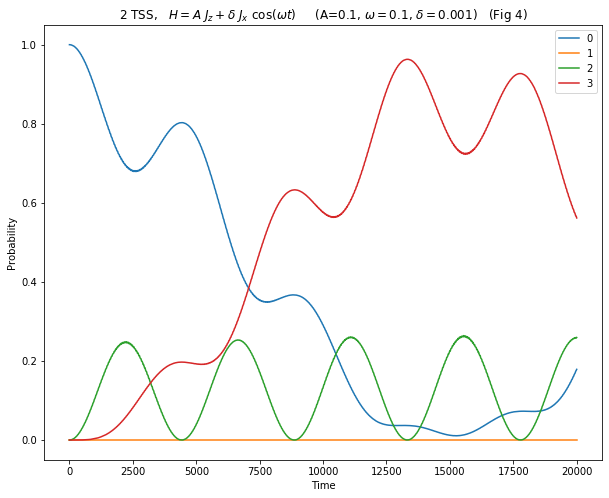

In [66]:
df.plot(figsize=(10,8), 
        title = "2 TSS,   $H =A \ J_z + \delta \ J_x \  \cos (\omega t)$     (A=0.1, $\omega = 0.1$, $\delta=0.001$)   (Fig 4)")
plt.xlabel("Time")
plt.ylabel("Probability");

Fig 4 shows us that the system evolves away from the lowest energy level 0 and towards the highest energy level 3 with a high chance (50%) of finding the system in a state of zero energy (level 1) part way through - nothing controversial here.

Fig 4 also shows us that energy level 2 is never occupied - this is unexpected. To understand what's going on, we need to look at the stationary states of the unperturbed system in the Dicke basis.

In [68]:
prettify_states(ekets,mm_list)

,0,1,2,3
"(+, +)",0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j
"(+, -)",0.0+0.0j,-0.7+0.0j,-0.7+0.0j,0.0+0.0j
"(-, +)",0.0+0.0j,0.7+0.0j,-0.7+0.0j,0.0+0.0j
"(-, -)",-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


We can see that the stationary states of the unperturbed system are the same as the Dicke basis states i.e. the states of constant energy and constant angular momentum [share a common basis](https://ocw.mit.edu/courses/physics/8-04-quantum-physics-i-spring-2013/study-materials/MIT8_04S13_OnCommEigenbas.pdf). This is only possible if the commutator between the operators is zero - let's check.

In [37]:
H = A*J[2] + delta*J[0]
J2 = J[0]*J[0] + J[1]*J[1] + J[2]*J[2]
commutator(H,J2)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

The zero commutator of $J^2$ with the Hamiltonian means something more - it means that angular momentum is conserved over time, i.e. if we start in a state of a particular $j$ then we can't move to a new $j$. This explains the flat line in Fig 4. We started the simulation in energy level 0 (aka $|1, -1 \rangle$) but the system is incapable of going level 2 (aka $|0, 0 \rangle$) because it has a different angular momentum $j$.

We can confirm these ideas by starting the system off in level 2 instead of level 0:

In [38]:
result, ekets = simulate(A, delta, J, times, 2)

In [39]:
psi, P = make_p_psi_arrays(result.states, ekets) 

In [40]:
df = pd.DataFrame(P, index=times)

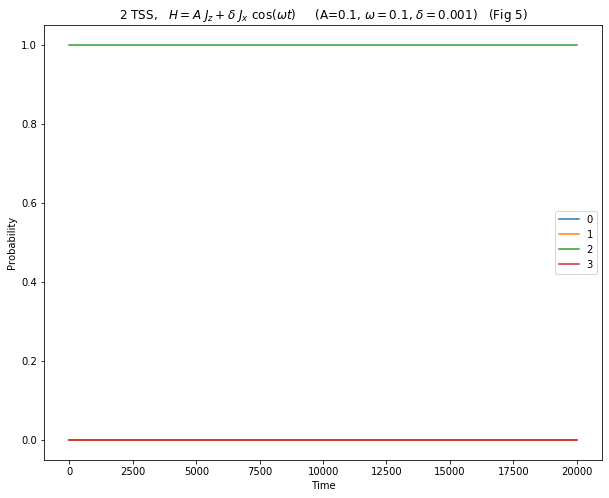

In [41]:
df.plot(figsize=(10,8), 
        title = "2 TSS,   $H =A \ J_z + \delta \ J_x \  \cos (\omega t)$     (A=0.1, $\omega = 0.1$, $\delta=0.001$)   (Fig 5)")
plt.xlabel("Time")
plt.ylabel("Probability");

Fig 5 shows that the system doesn't change over time. This is because there is only 1 state with $j=0$, namely $|0,0\rangle$, and so there is nowhere for the state to evolve to without violating the conservation of "angular momentum". 

We can now also solve the mystery of why level 1 in fig 1 appears to different to the others - it's because it has a different angular "angular momentum" ($j=0$ for level 1, $j=1$ for the others).

> I use quotation marks around "angular momentum" to remind us that it's not really angular momentum, but something that is mathematically equivalent. Some people call $j$ the Dicke cooperation number to remind us of this distinction.

Conservation of $j$ allows to hugely reduce the computationally resources required for simulating many TSS. Let's see how this works before we finish up.

In [43]:
pm = tensor(basis(2,0), basis(2,1))
pm

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

In [9]:
J = jspin(2, basis="uncoupled")

In [10]:
H0 = A*J[2]  # Unperturbed system

H1 =  delta*J[0] # Perturbation

H_list = [H0,[H1,'cos(w*t)']]

evals, ekets = H0.eigenstates()  # Find stationary states of unperturbed system

psi0 = pm

result = sesolve(H_list, psi0, times, args={'w':A})

In [11]:
psi, P = make_p_psi_arrays(result.states) 

In [12]:
df = pd.DataFrame(P, index=times)

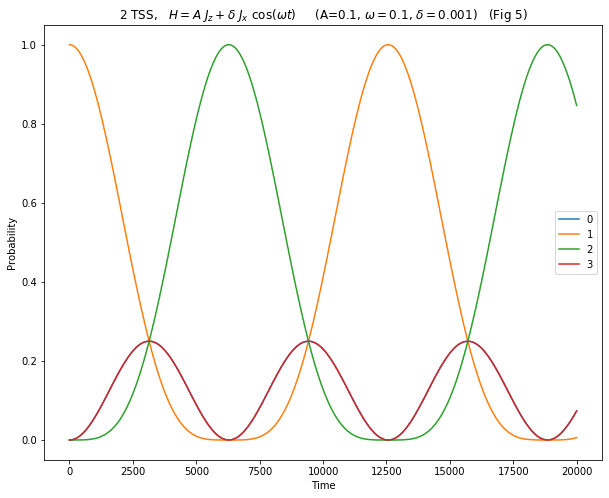

In [13]:
df.plot(figsize=(10,8), 
        title = "2 TSS,   $H =A \ J_z + \delta \ J_x \  \cos (\omega t)$     (A=0.1, $\omega = 0.1$, $\delta=0.001$)   (Fig 5)")
plt.xlabel("Time")
plt.ylabel("Probability");

In [14]:
bra_labels, ket_labels = make_braket_labels(mm_list)

In [15]:
P.shape

(1000, 4)

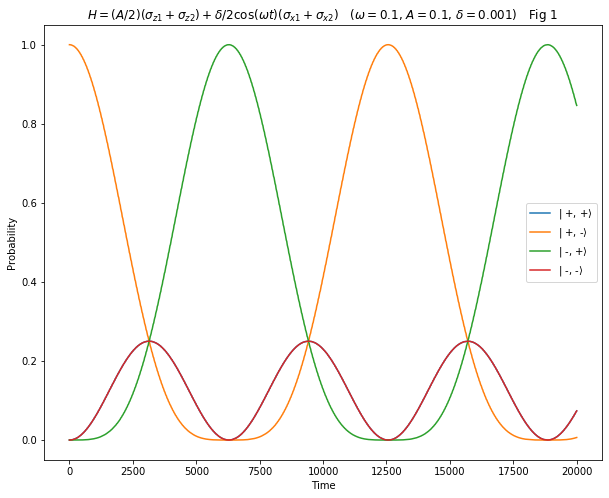

In [17]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[1]):
    plt.plot(times, P[:,i], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H = (A / 2) (\sigma_{z1} + \sigma_{z2})  + \delta /2 \cos (\omega t)(\sigma_{x1} +\sigma_{x2} )$   ($\omega=0.1$, $A = 0.1$, $\delta=0.001$)   Fig 1")
plt.show();

In [56]:
delta = 0.1

In [57]:
H0 = A*J[2]  # Unperturbed system

H1 =  delta*J[0] # Perturbation

In [61]:
J[2]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. -1.]]

In [65]:
tensor(qeye(2), sigmaz()) + tensor(sigmaz(), qeye(2))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 2.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. -2.]]

In [62]:
J[0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.5 0.5 0. ]
 [0.5 0.  0.  0.5]
 [0.5 0.  0.  0.5]
 [0.  0.5 0.5 0. ]]

In [58]:
H = H0 + H1

In [59]:
H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.1   0.05  0.05  0.  ]
 [ 0.05  0.    0.    0.05]
 [ 0.05  0.    0.    0.05]
 [ 0.    0.05  0.05 -0.1 ]]

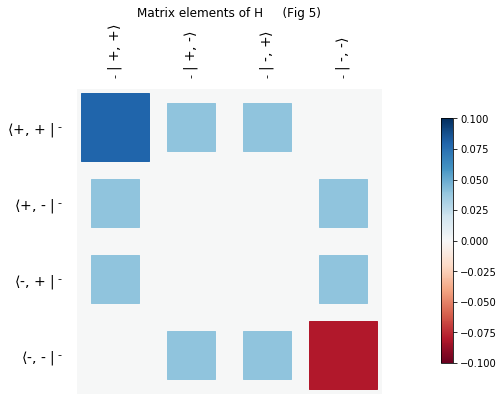

In [60]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

# 5.7 - Isolated universes

When we began this tutorial, we described the states of 2 TSS in the |±, ±> basis because it felt natural. For $N$ TSS, such a description creates a very large number of states to consider - specifically $2^{N}$.

Now that we have learnt about the conservation of $j$, not all of the $2^{N}$ states need to be considered in every simulation. Each value of $j$ lives in its own universe (much like [parity in tutorial 4](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb#4.4---Parity)) and is disconnected from the others. The largest number of states that we need to consider comes when we have maximum $j$, i.e. $j_{\text{max}} = \frac{1}{2} N$. In this case, the number of possible $m$ values is $2j+1 = N+1$ - this grows linear with $N$ rather than exponentially so is much more favourable for doing simulations for large $N$.

> ADVANCED: In general, there are some subtleties to consider when doing this. There can be many degenerate $j$ universes which might need to be considered depending on the problem at hand (see last paragraph of [Permutational Invariant Quantum Solver](http://qutip.org/docs/latest/guide/dynamics/dynamics-piqs.html)). For now, we don't need to worry about this so we will put a pin in this advanced topic and return to it in a later tutorial.

How do we simulate specific $j$ universe?

Much like in tutorial 4, we can use the [`extract_states`](http://qutip.org/docs/latest/apidoc/classes.html?highlight=extract_states#qutip.Qobj.extract_states) function to only select the relevant $j$'s from the Hamiltonian. To do this, we need to keep track of where the different $j$'s live. We'll create a function for this.

In [44]:
def j_states_list(num_tss):
    i=0
    
    jm_list = []   # This will be the ordered list of the basis states
    j_index = {}   # This will be a python doctionary to allow us to easily find the rows/columns for a specific j

    # Get the j values for 2 TSS and order them high to low
    js = j_vals(num_tss)[::-1]
    
    for j in js:
        j_index[j] = []
        # for each j value get the different possible m's and order them high to low
        ms = m_vals(j)[::-1]
        for m in ms:
            j_index[j].append(i)
            jm_list.append((j,m))
            i+=1
    return j_index, jm_list

Let's get ready to re-run the simulation that created Fig 4 but this time only looking at $j=1$ universe.

For $N=2$ what does our `j_states_list` function tell us?

In [45]:
j_index, jm_list = j_states_list(2)

We are interested in $j=1$, this corresponds to the following rows/columns in the Hamiltonian:

In [46]:
j_index[1]

[0, 1, 2]

Again much like tutorial 4, the next step is to extract the states in rows/columns `[0,1,2]` from the operators that make up the Hamiltonian (i.e. the $J$'s).

We'll make a function to automate this process. It takes two arguments:
1. The number of TSS we want to simulate
2. The value of $j$ we want to simulate

In [47]:
def make_operators(num_tss, j):
    
    j_index, jm_list = j_states_list(num_tss)
    
    # Check that the j we want to simulate is a valid j for this number of TSS.
    # If we don't choose a valid j then return a helpful list of valid options
    try:
        j_index[j]
    except:
        raise Exception(f"j needs to be one of {j_vals(num_tss)}")
    
    # Create the J operator for the number of TSS we have specified
    J = jspin(num_tss)
    
    # Now we extract only the states (and labels for those states) for the j we have specified 
    J = [Ji.extract_states(j_index[j]) for Ji in J]  # Loops through the 3 J components and does `extract` for each one
    jm_list = [jm_list[j] for i in j_index[j]]  
    
    
    return J, jm_list

We are ready. Let's re-simulate fig 4.

In [48]:
J, jm_list = make_operators(2, 1)

In [49]:
result, ekets = simulate(A, delta, J, times, 0)

In [50]:
psi, P = make_p_psi_arrays(result.states, ekets) 

In [51]:
df = pd.DataFrame(P, index=times)

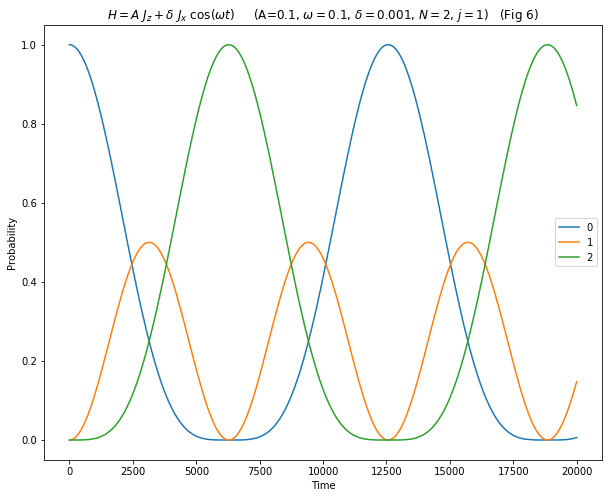

In [52]:
df.plot(figsize=(10,8), 
        title = "$H =A \ J_z + \delta \ J_x \  \cos (\omega t)$     (A=0.1, $\omega = 0.1$, $\delta=0.001$, $N=2$, $j=1$)   (Fig 6)")
plt.xlabel("Time")
plt.ylabel("Probability");

We can see in Fig 6 that we have successfully removed the flat line, corresponding to $j=0$, from our simulation with no changes to the evolution of the other states - as we would expect.

Great! Now we are able to simulate an arbitrary number of TSS but just chaging a couple of numbers in our functions. Let's try it out with $N=6$.

What $j$ values can we have for 6 TSS?

In [53]:
j_vals(6)

array([0., 1., 2., 3.])

Let's simulate the $j=3$ universe.

In [54]:
J, jm_list = make_operators(6, 3)

In [55]:
result, ekets = simulate(A, delta, J, times, 0)

In [56]:
psi, P = make_p_psi_arrays(result.states, ekets)

In [57]:
df = pd.DataFrame(P, index=times)

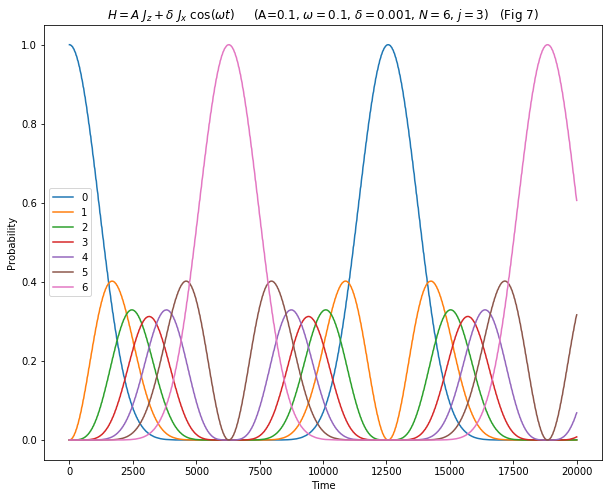

In [58]:
df.plot(figsize=(10,8), 
        title = "$H =A \ J_z + \delta \ J_x \  \cos (\omega t)$     (A=0.1, $\omega = 0.1$, $\delta=0.001$, $N=6$, $j=3$)   (Fig 7)")
plt.xlabel("Time")
plt.ylabel("Probability");

Fig 7 shows us something new. A system of 6 TSS can raise/lower its energy by an amount that is much greater than the individual TSS transition energy $\omega$. We see that the energy can changed by $6\omega$. It is able to do this by sequentially moving from one energy level to the next, each with a transition energy of $\omega$.

We can imagine that when we re-introduce the quantised field back into the picture we might get a similar step-wise release/absorption of of energy through a process creation/destruction of many small energy bosons.

You'll have to wait and see.

## Next up...

Now that we've got all the tools needed to simulate an arbitrary number of TSS, we can get back into discovery mode and start playing with a spin boson model with more than 1 TSS - often referred to as the [Dicke model](http://dx.doi.org/10.1002/qute.201800043).